# Hierarchical Control Architecture

## MPC Planning + LQR Tracking

This notebook explores a hierarchical control architecture that separates **trajectory planning** (MPC on compute layer) from **trajectory tracking** (LQR+FF on real-time layer).

### The Key Insight

From the Error Dynamics notebook, we learned that **LQR+FF often outperforms MPC for trajectory tracking** when:
- The trajectory is already smooth and feasible
- Constraints aren't being hit
- Good feedforward is available

So when *does* MPC add value? **When you need to plan or replan trajectories**, not just track them.

### Architecture Overview

```
┌─────────────────────────────────────────────────────────────┐
│                    COMPUTE LAYER (Linux)                     │
│  ┌─────────────┐    ┌─────────────┐    ┌─────────────────┐  │
│  │  Perception │───▶│ MPC Planner │───▶│ Trajectory      │  │
│  │  (sensors)  │    │ (10-50 Hz)  │    │ (x_ref, u_ref)  │  │
│  └─────────────┘    └─────────────┘    └────────┬────────┘  │
└─────────────────────────────────────────────────┼───────────┘
                                                  │ Trajectory
                                                  │ updates
                                                  ▼
┌─────────────────────────────────────────────────────────────┐
│                    RT LAYER (Zephyr)                         │
│  ┌─────────────┐    ┌─────────────┐    ┌─────────────────┐  │
│  │ State Est.  │───▶│  LQR + FF   │───▶│ Motor Control   │  │
│  │ (Kalman)    │    │ (200+ Hz)   │    │ (PWM)           │  │
│  └─────────────┘    └─────────────┘    └─────────────────┘  │
└─────────────────────────────────────────────────────────────┘
```

### When Each Layer Adds Value

| Layer | Adds Value When | Examples |
|-------|-----------------|----------|
| **MPC Planning** | Constraints, obstacles, dynamic goals | Obstacle avoidance, speed limits |
| **LQR Tracking** | Fast response to disturbances | Motor noise, sensor jitter |

## Imports and Setup

In [ ]:
import sys
sys.path.insert(0, "..")  # Add parent directory for module imports

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_discrete_are
from scipy import sparse
import osqp

from simulation import discretize_system

In [2]:
# Robot parameters
L = 0.14      # wheelbase [m]
tau = 0.2     # motor time constant [s]
v0 = 0.25     # nominal speed [m/s]
u_max = 0.5   # max wheel command [m/s]

# Dimensions
n_states = 5
n_inputs = 2

# Noise (for simulation)
Q_noise = np.diag([1e-5, 1e-5, 1e-6, 1e-4, 1e-4])

print(f"Robot: L={L*100:.0f}cm, tau={tau}s, v0={v0}m/s")

Robot: L=14cm, tau=0.2s, v0=0.25m/s


## Core Dynamics Functions

In [3]:
def nonlinear_dynamics(x, u, dt, L, tau):
    """Propagate state using nonlinear tank drive dynamics."""
    x_pos, y_pos, theta, v_l, v_r = x
    u_l, u_r = u
    
    v_avg = (v_l + v_r) / 2.0
    
    return np.array([
        x_pos + v_avg * np.cos(theta) * dt,
        y_pos + v_avg * np.sin(theta) * dt,
        theta + (v_r - v_l) / L * dt,
        v_l + (-v_l + u_l) / tau * dt,
        v_r + (-v_r + u_r) / tau * dt
    ])


def angle_wrap(theta):
    """Wrap angle to [-pi, pi]."""
    return (theta + np.pi) % (2 * np.pi) - np.pi


def state_error(x, x_ref):
    """Compute state error with proper angle wrapping."""
    e = x - x_ref
    e[2] = angle_wrap(e[2])
    return e


def compute_jacobians(x_ref, L, tau):
    """Compute linearized A, B matrices around a reference state."""
    theta = x_ref[2]
    v_l, v_r = x_ref[3], x_ref[4]
    v_avg = (v_l + v_r) / 2
    
    A = np.array([
        [0, 0, -np.sin(theta) * v_avg, np.cos(theta) / 2, np.cos(theta) / 2],
        [0, 0,  np.cos(theta) * v_avg, np.sin(theta) / 2, np.sin(theta) / 2],
        [0, 0, 0, -1/L, 1/L],
        [0, 0, 0, -1/tau, 0],
        [0, 0, 0, 0, -1/tau]
    ])
    
    B = np.array([
        [0, 0],
        [0, 0],
        [0, 0],
        [1/tau, 0],
        [0, 1/tau]
    ])
    
    return A, B


print("Core dynamics functions defined.")

Core dynamics functions defined.


## LQR Tracker (RT Layer)

The LQR tracker runs on the real-time microcontroller at high frequency (200+ Hz). It:
1. Receives trajectory points $(x_{ref}, u_{ref})$ from the compute layer
2. Estimates current state via Kalman filter
3. Applies feedforward + feedback control: $u = u_{ref} - K(x - x_{ref})$

### Key Properties
- **Deterministic**: Fixed computation time (~10-50 μs)
- **Simple**: Matrix multiply + saturation
- **Robust**: Handles sensor noise, small disturbances

In [4]:
class LQRTracker:
    """
    LQR + Feedforward trajectory tracker.
    
    Designed for real-time execution on microcontroller.
    Computation: single matrix multiply (~10-50 μs on Cortex-M4).
    """
    
    def __init__(self, L, tau, dt, Q, R, v_nominal=0.25):
        """
        Precompute LQR gain for nominal operating point.
        
        Args:
            L, tau: Robot parameters
            dt: Control timestep
            Q: State cost (5x5)
            R: Control cost (2x2)
            v_nominal: Nominal velocity for linearization
        """
        self.L = L
        self.tau = tau
        self.dt = dt
        self.u_max = 0.5
        
        # Linearize at nominal forward motion (theta=0, v=v_nominal)
        x_nom = np.array([0, 0, 0, v_nominal, v_nominal])
        Ac, Bc = compute_jacobians(x_nom, L, tau)
        
        # Discretize
        Ad = np.eye(5) + dt * Ac
        Bd = dt * Bc
        
        # Solve DARE for LQR gain
        P = solve_discrete_are(Ad, Bd, Q, R)
        self.K = np.linalg.solve(R + Bd.T @ P @ Bd, Bd.T @ P @ Ad)
        
        print(f"LQR Tracker initialized (gain norm: {np.linalg.norm(self.K):.2f})")
    
    def compute_control(self, x_current, x_ref, u_ref):
        """
        Compute control: u = u_ref - K @ (x - x_ref)
        
        This is the ONLY function that runs in the RT loop.
        Must be fast and deterministic.
        """
        e = state_error(x_current, x_ref)
        u = u_ref - self.K @ e
        return np.clip(u, -self.u_max, self.u_max)


# Create LQR tracker with tuned weights
Q_lqr = np.diag([20.0, 20.0, 5.0, 0.1, 0.1])  # Position > heading > velocity
R_lqr = np.diag([1.0, 1.0])

dt_rt = 0.005  # 200 Hz RT loop
lqr_tracker = LQRTracker(L, tau, dt_rt, Q_lqr, R_lqr, v_nominal=v0)

LQR Tracker initialized (gain norm: 7.04)


## MPC Planner (Compute Layer)

The MPC planner runs on the compute platform (Linux) at moderate frequency (10-50 Hz). It:
1. Receives goal waypoints and obstacle information
2. Solves an optimal control problem over a 1-3 second horizon
3. Outputs a smooth trajectory $(x_{ref}(t), u_{ref}(t))$ that:
   - Reaches the goal
   - Avoids obstacles
   - Respects actuator limits
   - Is physically realizable (smooth, respects motor dynamics)

### When MPC Planning Adds Value

MPC planning is essential when:
- **Obstacles require path deviation** — can't just follow waypoints blindly
- **Actuator limits matter** — need to plan around saturation
- **Preview helps** — e.g., slowing before a sharp turn
- **Goals change dynamically** — replanning is needed

In [5]:
class MPCPlanner:
    """
    MPC-based trajectory planner using OSQP.
    
    Runs on compute layer at 10-50 Hz.
    Generates smooth, constraint-satisfying trajectories.
    """
    
    def __init__(self, L, tau, dt, horizon_time, Q, R, R_rate, u_max):
        """
        Args:
            L, tau: Robot parameters
            dt: Planning timestep (coarser than RT, e.g., 0.05s)
            horizon_time: Planning horizon in seconds
            Q: State cost
            R: Control cost
            R_rate: Control rate cost (for smooth trajectories)
            u_max: Actuator limit
        """
        self.L = L
        self.tau = tau
        self.dt = dt
        self.N = int(horizon_time / dt)
        self.Q = Q
        self.R = R
        self.R_rate = R_rate
        self.u_max = u_max
        
        self.solver = None
        self.prev_u = None
        
    def _build_prediction_matrices(self, x_current):
        """Build matrices for x = S @ x0 + R @ u."""
        Ac, Bc = compute_jacobians(x_current, self.L, self.tau)
        Ad = np.eye(5) + self.dt * Ac
        Bd = self.dt * Bc
        
        N, nx, nu = self.N, 5, 2
        
        # S matrix: [Ad; Ad^2; ...]
        S = np.zeros((N * nx, nx))
        Ad_power = np.eye(nx)
        for i in range(N):
            Ad_power = Ad_power @ Ad
            S[i*nx:(i+1)*nx, :] = Ad_power
        
        # R matrix: lower triangular
        R_pred = np.zeros((N * nx, N * nu))
        for i in range(N):
            for j in range(i + 1):
                power = i - j
                Ad_pow = np.linalg.matrix_power(Ad, power)
                R_pred[i*nx:(i+1)*nx, j*nu:(j+1)*nu] = Ad_pow @ Bd
        
        return S, R_pred
    
    def plan_trajectory(self, x_current, x_goal, obstacles=None):
        """
        Plan trajectory from current state to goal.
        
        Args:
            x_current: Current state [x, y, theta, v_l, v_r]
            x_goal: Goal state [x, y, theta, v_l, v_r]
            obstacles: List of (x, y, radius) obstacles (optional)
            
        Returns:
            x_traj: State trajectory (5 x N+1)
            u_traj: Control trajectory (2 x N)
        """
        N, nx, nu = self.N, 5, 2
        
        # Build prediction matrices
        S, R_pred = self._build_prediction_matrices(x_current)
        
        # Goal trajectory (linear interpolation for now)
        x_ref_flat = np.zeros(N * nx)
        for k in range(N):
            frac = (k + 1) / N
            x_interp = x_current + frac * (x_goal - x_current)
            x_interp[2] = x_current[2] + frac * angle_wrap(x_goal[2] - x_current[2])
            x_ref_flat[k*nx:(k+1)*nx] = x_interp
        
        # Free response
        x_free = S @ x_current
        
        # Build QP cost matrices
        Q_bar = sparse.block_diag([self.Q] * N)
        R_bar = sparse.block_diag([self.R] * N)
        
        # Rate penalty matrix
        D = np.zeros((N * nu, N * nu))
        for k in range(N):
            D[k*nu:(k+1)*nu, k*nu:(k+1)*nu] = np.eye(nu)
            if k > 0:
                D[k*nu:(k+1)*nu, (k-1)*nu:k*nu] = -np.eye(nu)
        D = sparse.csc_matrix(D)
        R_rate_bar = sparse.block_diag([self.R_rate] * N)
        
        # QP: min 1/2 u'Pu + q'u
        f = x_free - x_ref_flat
        for k in range(N):
            f[k*nx + 2] = angle_wrap(f[k*nx + 2])
        
        P = R_pred.T @ Q_bar @ R_pred + R_bar.toarray() + D.T @ R_rate_bar @ D
        P = sparse.csc_matrix(P)
        q = R_pred.T @ Q_bar @ f
        
        # Constraints: -u_max <= u <= u_max
        A_ineq = sparse.eye(N * nu)
        l = -self.u_max * np.ones(N * nu)
        u_upper = self.u_max * np.ones(N * nu)
        
        # Solve QP
        if self.solver is None:
            self.solver = osqp.OSQP()
            self.solver.setup(P, q, A_ineq, l, u_upper,
                            warm_start=True, verbose=False,
                            eps_abs=1e-4, eps_rel=1e-4)
        else:
            self.solver.update(Px=sparse.triu(P).data, q=q)
        
        # Warm start
        if self.prev_u is not None:
            u_warm = np.zeros(N * nu)
            u_warm[:-nu] = self.prev_u[nu:]
            u_warm[-nu:] = self.prev_u[-nu:]
            self.solver.warm_start(x=u_warm)
        
        result = self.solver.solve()
        
        if result.info.status != 'solved':
            # Fallback: straight line to goal with cruise speed
            u_traj = np.tile(np.array([v0, v0]), (N, 1)).T
            x_traj = np.zeros((5, N + 1))
            x_traj[:, 0] = x_current
            for k in range(N):
                x_traj[:, k+1] = nonlinear_dynamics(x_traj[:, k], u_traj[:, k], self.dt, self.L, self.tau)
            return x_traj, u_traj
        
        self.prev_u = result.x
        
        # Extract trajectory
        u_opt = result.x.reshape((N, 2)).T
        x_traj = np.zeros((5, N + 1))
        x_traj[:, 0] = x_current
        for k in range(N):
            x_traj[:, k+1] = nonlinear_dynamics(x_traj[:, k], u_opt[:, k], self.dt, self.L, self.tau)
        
        return x_traj, u_opt


# Create MPC planner
Q_mpc = np.diag([10.0, 10.0, 5.0, 0.1, 0.1])
R_mpc = np.diag([0.1, 0.1])
R_rate_mpc = np.diag([2.0, 2.0])  # Smooth control for motor dynamics

dt_plan = 0.05  # 20 Hz planning
horizon = 2.0   # 2 second horizon

mpc_planner = MPCPlanner(L, tau, dt_plan, horizon, Q_mpc, R_mpc, R_rate_mpc, u_max)

print(f"MPC Planner initialized:")
print(f"  Horizon: {horizon}s ({mpc_planner.N} steps)")
print(f"  Planning dt: {dt_plan}s ({1/dt_plan:.0f} Hz)")

MPC Planner initialized:
  Horizon: 2.0s (40 steps)
  Planning dt: 0.05s (20 Hz)


## Hierarchical Simulation

Now we simulate the full architecture:
1. **MPC Planner** runs at 20 Hz, generating 2-second trajectory chunks
2. **LQR Tracker** runs at 200 Hz, tracking the current trajectory point
3. Trajectory buffer interpolates between planning updates

In [6]:
class TrajectoryBuffer:
    """
    Buffer that stores planned trajectory and provides interpolated references.
    
    Sits between MPC planner (slow) and LQR tracker (fast).
    """
    
    def __init__(self, dt_plan, dt_rt):
        self.dt_plan = dt_plan
        self.dt_rt = dt_rt
        self.x_traj = None
        self.u_traj = None
        self.t_start = 0.0
        
    def update(self, x_traj, u_traj, t_current):
        """Update trajectory from planner."""
        self.x_traj = x_traj
        self.u_traj = u_traj
        self.t_start = t_current
        
    def get_reference(self, t_current):
        """Get interpolated reference for current time."""
        if self.x_traj is None:
            return np.zeros(5), np.zeros(2)
        
        # Time since trajectory start
        dt = t_current - self.t_start
        
        # Find trajectory index
        k = int(dt / self.dt_plan)
        k = min(k, self.x_traj.shape[1] - 2)
        k = max(k, 0)
        
        # Linear interpolation within segment
        frac = (dt - k * self.dt_plan) / self.dt_plan
        frac = np.clip(frac, 0, 1)
        
        x_ref = self.x_traj[:, k] + frac * (self.x_traj[:, k+1] - self.x_traj[:, k])
        x_ref[2] = angle_wrap(x_ref[2])
        
        # Control reference (hold for segment)
        u_ref = self.u_traj[:, min(k, self.u_traj.shape[1]-1)]
        
        return x_ref, u_ref


def run_hierarchical_simulation(waypoints, T_final, dt_rt, dt_plan, lqr, planner):
    """
    Run hierarchical control simulation.
    
    Args:
        waypoints: List of [x, y] goal positions
        T_final: Simulation duration
        dt_rt: RT loop timestep
        dt_plan: Planning timestep
        lqr: LQR tracker
        planner: MPC planner
    """
    N_rt = int(T_final / dt_rt)
    plan_interval = int(dt_plan / dt_rt)
    
    # Initial state
    x0 = np.array([waypoints[0][0], waypoints[0][1], 0.0, 0.0, 0.0])
    x_true = np.zeros((5, N_rt))
    u_hist = np.zeros((2, N_rt))
    x_true[:, 0] = x0
    
    # Trajectory buffer
    traj_buffer = TrajectoryBuffer(dt_plan, dt_rt)
    
    # Noise
    rng = np.random.default_rng(42)
    Q_chol = np.linalg.cholesky(Q_noise)
    
    # Current waypoint target
    wp_idx = 1
    
    print(f"Running hierarchical simulation: {T_final}s at {1/dt_rt:.0f} Hz RT, {1/dt_plan:.0f} Hz planning\"")
    
    for k in range(N_rt - 1):
        t = k * dt_rt
        
        # === PLANNING LAYER (runs at dt_plan intervals) ===
        if k % plan_interval == 0:
            # Check if we've reached current waypoint
            dist_to_wp = np.sqrt((x_true[0, k] - waypoints[wp_idx][0])**2 + 
                                  (x_true[1, k] - waypoints[wp_idx][1])**2)
            if dist_to_wp < 0.2 and wp_idx < len(waypoints) - 1:
                wp_idx += 1
                print(f"  t={t:.1f}s: Reached waypoint {wp_idx-1}, targeting {wp_idx}\"")
            
            # Goal state: position from waypoint, heading toward it, cruise velocity
            goal_pos = waypoints[wp_idx]
            dx = goal_pos[0] - x_true[0, k]
            dy = goal_pos[1] - x_true[1, k]
            goal_heading = np.arctan2(dy, dx)
            x_goal = np.array([goal_pos[0], goal_pos[1], goal_heading, v0, v0])
            
            # Plan trajectory
            x_traj, u_traj = planner.plan_trajectory(x_true[:, k], x_goal)
            traj_buffer.update(x_traj, u_traj, t)
        
        # === TRACKING LAYER (runs every dt_rt) ===
        x_ref, u_ref = traj_buffer.get_reference(t)
        u = lqr.compute_control(x_true[:, k], x_ref, u_ref)
        u_hist[:, k] = u
        
        # Propagate dynamics with noise
        w = Q_chol @ rng.standard_normal(5)
        x_true[:, k+1] = nonlinear_dynamics(x_true[:, k], u, dt_rt, L, tau) + w
    
    return x_true, u_hist


# Define waypoints
waypoints = [
    [0.0, 0.0],
    [2.0, 2.0],
    [4.0, 1.0],
    [5.0, 3.0],
]

# Run simulation
T_final = 30.0
x_hier, u_hier = run_hierarchical_simulation(
    waypoints, T_final, dt_rt, dt_plan, lqr_tracker, mpc_planner
)

Running hierarchical simulation: 30.0s at 200 Hz RT, 20 Hz planning"


/home/smitj/Git/benji/.venv/lib/python3.13/site-packages/osqp/interface.py:229: UserWarning: Converting sparse A to a CSC matrix. This may take a while...
  warnings.warn('Converting sparse A to a CSC matrix. This may take a while...')


  t=13.9s: Reached waypoint 1, targeting 2"
  t=24.1s: Reached waypoint 2, targeting 3"
  t=24.1s: Reached waypoint 2, targeting 3"


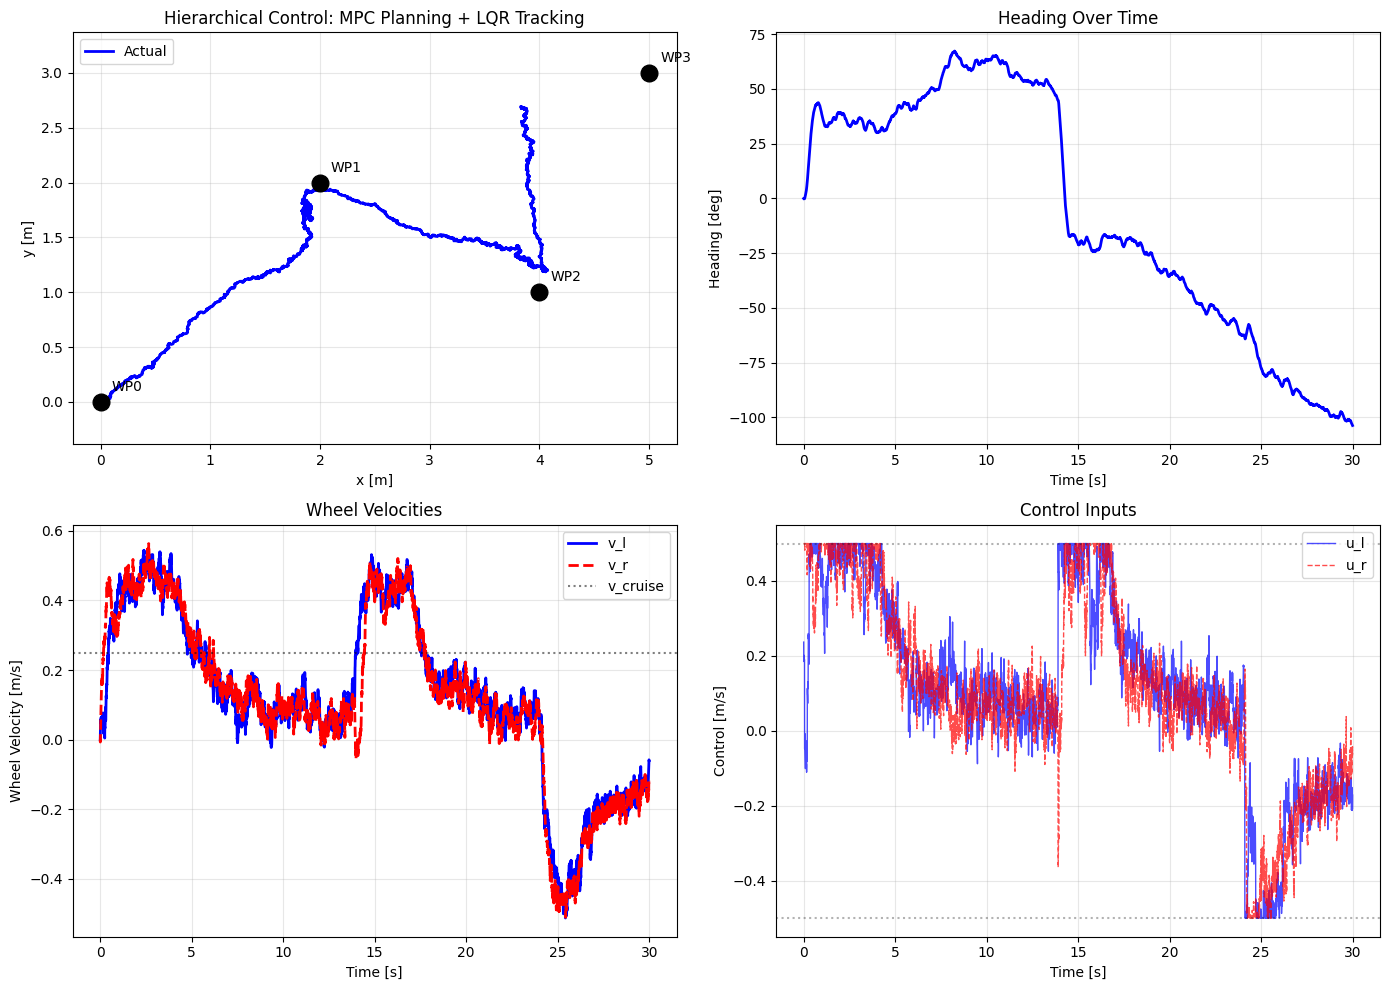


Simulation complete: 30.0s with 6000 RT steps")
Final position: (3.84, 2.69) m")


In [7]:
# Visualize results
t = np.arange(x_hier.shape[1]) * dt_rt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Trajectory
ax = axes[0, 0]
ax.plot(x_hier[0, :], x_hier[1, :], 'b-', linewidth=2, label='Actual')
for i, wp in enumerate(waypoints):
    ax.plot(wp[0], wp[1], 'ko', markersize=12)
    ax.annotate(f'WP{i}', (wp[0]+0.1, wp[1]+0.1), fontsize=10)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.axis('equal')
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_title('Hierarchical Control: MPC Planning + LQR Tracking')

# Heading
ax = axes[0, 1]
ax.plot(t, np.degrees(x_hier[2, :]), 'b-', linewidth=2)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Heading [deg]')
ax.grid(True, alpha=0.3)
ax.set_title('Heading Over Time')

# Velocities
ax = axes[1, 0]
ax.plot(t, x_hier[3, :], 'b-', linewidth=2, label='v_l')
ax.plot(t, x_hier[4, :], 'r--', linewidth=2, label='v_r')
ax.axhline(v0, color='k', linestyle=':', alpha=0.5, label='v_cruise')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Wheel Velocity [m/s]')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_title('Wheel Velocities')

# Control inputs
ax = axes[1, 1]
ax.plot(t[:-1], u_hier[0, :-1], 'b-', linewidth=1, label='u_l', alpha=0.7)
ax.plot(t[:-1], u_hier[1, :-1], 'r--', linewidth=1, label='u_r', alpha=0.7)
ax.axhline(u_max, color='k', linestyle=':', alpha=0.3)
ax.axhline(-u_max, color='k', linestyle=':', alpha=0.3)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Control [m/s]')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_title('Control Inputs')

plt.tight_layout()
plt.show()

print(f"\nSimulation complete: {T_final}s with {int(T_final/dt_rt)} RT steps\")")
print(f"Final position: ({x_hier[0, -1]:.2f}, {x_hier[1, -1]:.2f}) m\")")

## When MPC Planning Matters: Dynamic Replanning

The real value of MPC planning emerges when conditions change and replanning is needed. 

### Scenario: New Obstacle Appears

Here we simulate a scenario where:
1. Robot is navigating toward a waypoint
2. An obstacle is detected mid-trajectory
3. MPC replans around the obstacle
4. LQR tracker smoothly follows the new plan

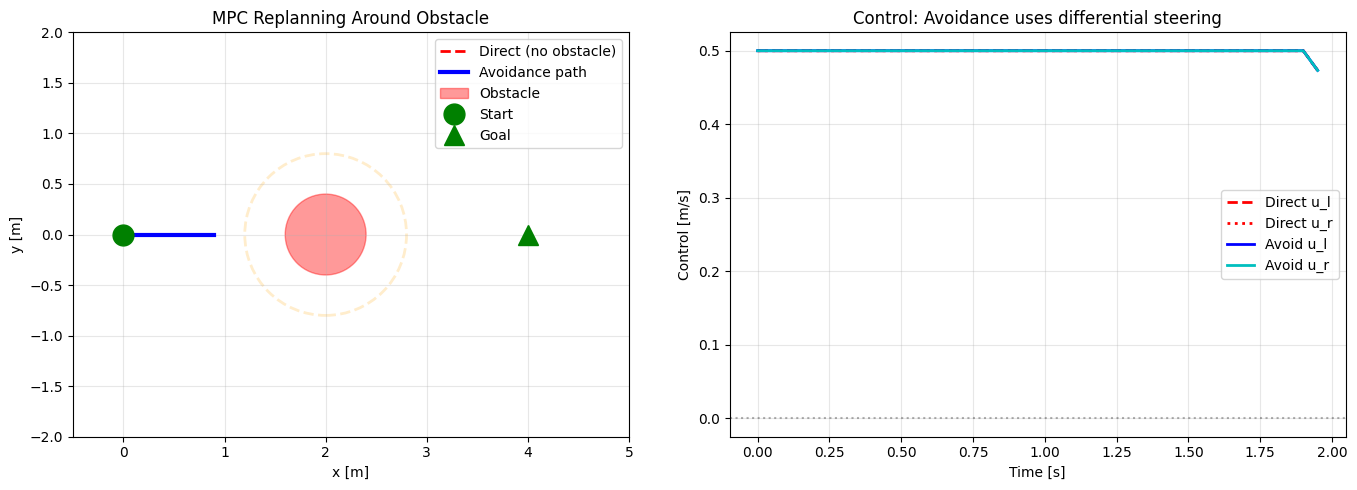


Key insight: MPC planning generates the avoidance trajectory.
The avoidance path requires different left/right wheel speeds to curve around.
LQR tracker would then follow this trajectory at 200 Hz.


In [8]:
class MPCPlannerWithObstacles(MPCPlanner):
    """
    MPC Planner that can avoid circular obstacles.
    
    Uses reference trajectory modification for obstacle avoidance.
    For production, you'd want proper constraint handling.
    """
    
    def plan_trajectory(self, x_current, x_goal, obstacles=None):
        """
        Plan trajectory avoiding obstacles.
        
        obstacles: List of (x, y, radius) tuples
        """
        N, nx, nu = self.N, 5, 2
        
        # Build prediction matrices
        S, R_pred = self._build_prediction_matrices(x_current)
        
        # Goal trajectory (straight line as initial guess)
        x_ref_flat = np.zeros(N * nx)
        for k in range(N):
            frac = (k + 1) / N
            x_interp = x_current + frac * (x_goal - x_current)
            x_interp[2] = x_current[2] + frac * angle_wrap(x_goal[2] - x_current[2])
            x_ref_flat[k*nx:(k+1)*nx] = x_interp
        
        # If obstacles present, bias the reference away from them
        if obstacles:
            for k in range(N):
                x_k = x_ref_flat[k*nx]
                y_k = x_ref_flat[k*nx + 1]
                
                for obs_x, obs_y, obs_r in obstacles:
                    dx = x_k - obs_x
                    dy = y_k - obs_y
                    dist = np.sqrt(dx**2 + dy**2)
                    
                    # If too close, push reference away
                    safe_dist = obs_r * 3  # Keep 3x radius margin
                    if dist < safe_dist:
                        # Direction away from obstacle
                        if dist > 0.01:
                            push_x = dx / dist
                            push_y = dy / dist
                        else:
                            push_x, push_y = 0, 1  # Default: go up
                        
                        # Push amount (stronger when closer)
                        push_strength = (safe_dist - dist) * 1.5
                        x_ref_flat[k*nx] += push_x * push_strength
                        x_ref_flat[k*nx + 1] += push_y * push_strength
        
        # Free response
        x_free = S @ x_current
        
        # Build QP cost matrices
        Q_bar = sparse.block_diag([self.Q] * N)
        R_bar = sparse.block_diag([self.R] * N)
        
        # Rate penalty
        D = np.zeros((N * nu, N * nu))
        for k in range(N):
            D[k*nu:(k+1)*nu, k*nu:(k+1)*nu] = np.eye(nu)
            if k > 0:
                D[k*nu:(k+1)*nu, (k-1)*nu:k*nu] = -np.eye(nu)
        D = sparse.csc_matrix(D)
        R_rate_bar = sparse.block_diag([self.R_rate] * N)
        
        # QP cost
        f = x_free - x_ref_flat
        for k in range(N):
            f[k*nx + 2] = angle_wrap(f[k*nx + 2])
        
        P = R_pred.T @ Q_bar @ R_pred + R_bar.toarray() + D.T @ R_rate_bar @ D
        P = sparse.csc_matrix(P)
        q = R_pred.T @ Q_bar @ f
        
        # Constraints
        A_ineq = sparse.eye(N * nu)
        l = -self.u_max * np.ones(N * nu)
        u_upper = self.u_max * np.ones(N * nu)
        
        # Solve (fresh solver for obstacle scenarios)
        solver = osqp.OSQP()
        solver.setup(P, q, A_ineq, l, u_upper,
                    warm_start=True, verbose=False,
                    eps_abs=1e-4, eps_rel=1e-4)
        
        result = solver.solve()
        
        if result.info.status != 'solved':
            # Fallback
            u_traj = np.tile(np.array([v0, v0]), (N, 1)).T
            x_traj = np.zeros((5, N + 1))
            x_traj[:, 0] = x_current
            for k in range(N):
                x_traj[:, k+1] = nonlinear_dynamics(x_traj[:, k], u_traj[:, k], self.dt, self.L, self.tau)
            return x_traj, u_traj
        
        # Extract trajectory
        u_opt = result.x.reshape((N, 2)).T
        x_traj = np.zeros((5, N + 1))
        x_traj[:, 0] = x_current
        for k in range(N):
            x_traj[:, k+1] = nonlinear_dynamics(x_traj[:, k], u_opt[:, k], self.dt, self.L, self.tau)
        
        return x_traj, u_opt


def run_obstacle_avoidance_demo():
    """Demonstrate MPC replanning around obstacles."""
    
    # Simple scenario: go from (0,0) to (4,0) with obstacle at (2,0)
    x0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
    x_goal = np.array([4.0, 0.0, 0.0, v0, v0])
    
    # Obstacle in the direct path
    obstacle = (2.0, 0.0, 0.4)  # (x, y, radius)
    
    # Create planners
    planner_no_obs = MPCPlannerWithObstacles(L, tau, dt_plan, 2.0, Q_mpc, R_mpc, R_rate_mpc, u_max)
    planner_with_obs = MPCPlannerWithObstacles(L, tau, dt_plan, 2.0, Q_mpc, R_mpc, R_rate_mpc, u_max)
    
    # Plan without obstacle
    x_traj_direct, u_traj_direct = planner_no_obs.plan_trajectory(x0, x_goal, obstacles=None)
    
    # Plan with obstacle
    x_traj_avoid, u_traj_avoid = planner_with_obs.plan_trajectory(x0, x_goal, obstacles=[obstacle])
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    ax = axes[0]
    ax.plot(x_traj_direct[0, :], x_traj_direct[1, :], 'r--', linewidth=2, label='Direct (no obstacle)')
    ax.plot(x_traj_avoid[0, :], x_traj_avoid[1, :], 'b-', linewidth=3, label='Avoidance path')
    
    # Draw obstacle
    circle = plt.Circle((obstacle[0], obstacle[1]), obstacle[2], color='red', alpha=0.4, label='Obstacle')
    ax.add_patch(circle)
    # Safety margin
    circle_margin = plt.Circle((obstacle[0], obstacle[1]), obstacle[2]*2, 
                                color='orange', alpha=0.2, linestyle='--', fill=False, linewidth=2)
    ax.add_patch(circle_margin)
    
    ax.plot(x0[0], x0[1], 'go', markersize=15, label='Start', zorder=5)
    ax.plot(x_goal[0], x_goal[1], 'g^', markersize=15, label='Goal', zorder=5)
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')
    ax.set_xlim(-0.5, 5)
    ax.set_ylim(-2, 2)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')
    ax.set_title('MPC Replanning Around Obstacle')
    
    ax = axes[1]
    t_plan = np.arange(u_traj_avoid.shape[1]) * dt_plan
    ax.plot(t_plan, u_traj_direct[0, :], 'r--', linewidth=2, label='Direct u_l')
    ax.plot(t_plan, u_traj_direct[1, :], 'r:', linewidth=2, label='Direct u_r')
    ax.plot(t_plan, u_traj_avoid[0, :], 'b-', linewidth=2, label='Avoid u_l')
    ax.plot(t_plan, u_traj_avoid[1, :], 'c-', linewidth=2, label='Avoid u_r')
    ax.axhline(0, color='k', linestyle=':', alpha=0.3)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Control [m/s]')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_title('Control: Avoidance uses differential steering')
    
    plt.tight_layout()
    plt.show()
    
    print("\nKey insight: MPC planning generates the avoidance trajectory.")
    print("The avoidance path requires different left/right wheel speeds to curve around.")
    print("LQR tracker would then follow this trajectory at 200 Hz.")


run_obstacle_avoidance_demo()

Running dynamic obstacle avoidance simulation...
  t=3.0s: OBSTACLE DETECTED! Replanning...
  t=3.0s: OBSTACLE DETECTED! Replanning...


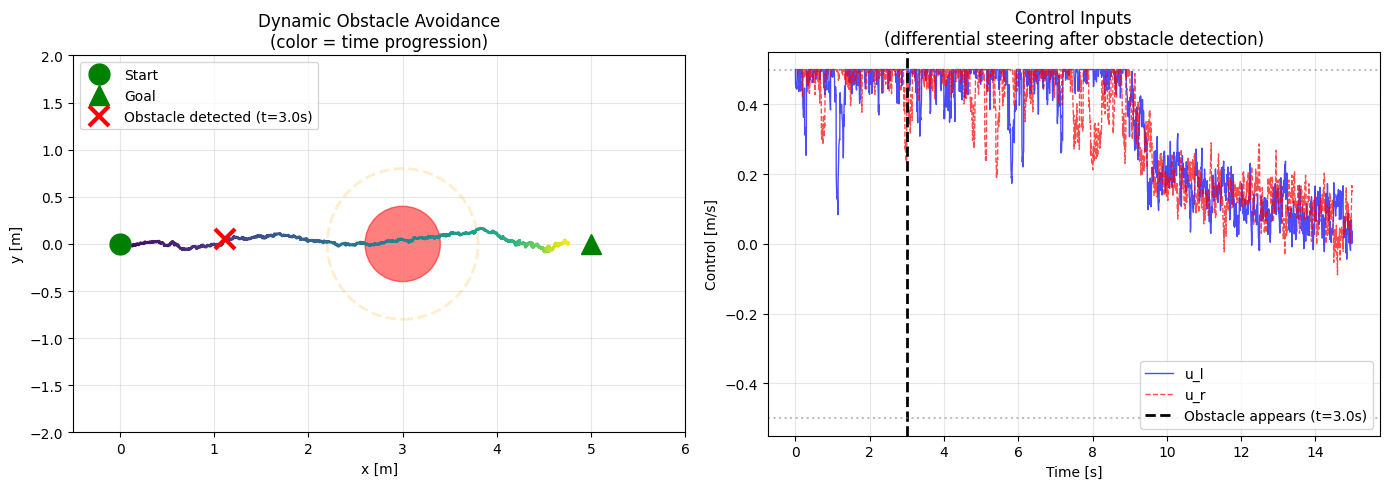


Results:
  Final position: (4.75, 0.00) m
  Goal position:  (5.00, 0.00) m
  Closest approach to obstacle: 0.04 m (obstacle radius: 0.40 m)
  Collision avoided: False


In [9]:
# More realistic demo: Full hierarchical sim with dynamic obstacle
def run_dynamic_obstacle_simulation():
    """
    Demonstrate the full value of hierarchical control:
    - MPC replans when obstacle appears
    - LQR smoothly transitions to new trajectory
    """
    
    # Scenario: Robot going from (0,0) to (5,0)
    # Obstacle appears at t=3s at position (3, 0)
    
    T_final = 15.0
    N_rt = int(T_final / dt_rt)
    plan_interval = int(dt_plan / dt_rt)
    
    x0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
    x_goal = np.array([5.0, 0.0, 0.0, v0, v0])
    
    # Obstacle appears at t=3s
    obstacle_appear_time = 3.0
    obstacle = (3.0, 0.0, 0.4)
    
    x_true = np.zeros((5, N_rt))
    u_hist = np.zeros((2, N_rt))
    x_true[:, 0] = x0
    
    traj_buffer = TrajectoryBuffer(dt_plan, dt_rt)
    planner = MPCPlannerWithObstacles(L, tau, dt_plan, 2.0, Q_mpc, R_mpc, R_rate_mpc, u_max)
    
    rng = np.random.default_rng(42)
    Q_chol = np.linalg.cholesky(Q_noise)
    
    replan_times = []
    obstacle_active = False
    
    print("Running dynamic obstacle avoidance simulation...")
    
    for k in range(N_rt - 1):
        t = k * dt_rt
        
        # Check if obstacle appears
        if t >= obstacle_appear_time and not obstacle_active:
            obstacle_active = True
            print(f"  t={t:.1f}s: OBSTACLE DETECTED! Replanning...")
        
        # Planning layer
        if k % plan_interval == 0:
            obstacles = [obstacle] if obstacle_active else None
            x_traj, u_traj = planner.plan_trajectory(x_true[:, k], x_goal, obstacles)
            traj_buffer.update(x_traj, u_traj, t)
            replan_times.append(t)
        
        # Tracking layer
        x_ref, u_ref = traj_buffer.get_reference(t)
        u = lqr_tracker.compute_control(x_true[:, k], x_ref, u_ref)
        u_hist[:, k] = u
        
        # Propagate
        w = Q_chol @ rng.standard_normal(5)
        x_true[:, k+1] = nonlinear_dynamics(x_true[:, k], u, dt_rt, L, tau) + w
    
    # Visualization
    t = np.arange(N_rt) * dt_rt
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    ax = axes[0]
    
    # Plot trajectory, color by time
    colors = plt.cm.viridis(np.linspace(0, 1, N_rt))
    for i in range(0, N_rt-1, 50):
        ax.plot(x_true[0, i:i+51], x_true[1, i:i+51], color=colors[i], linewidth=2)
    
    # Draw obstacle (with appearance effect)
    circle = plt.Circle((obstacle[0], obstacle[1]), obstacle[2], color='red', alpha=0.5)
    ax.add_patch(circle)
    circle_margin = plt.Circle((obstacle[0], obstacle[1]), obstacle[2]*2, 
                                color='orange', alpha=0.2, linestyle='--', fill=False, linewidth=2)
    ax.add_patch(circle_margin)
    
    ax.plot(x0[0], x0[1], 'go', markersize=15, label='Start', zorder=5)
    ax.plot(x_goal[0], x_goal[1], 'g^', markersize=15, label='Goal', zorder=5)
    
    # Mark where obstacle appeared
    idx_appear = int(obstacle_appear_time / dt_rt)
    ax.plot(x_true[0, idx_appear], x_true[1, idx_appear], 'rx', markersize=15, 
            markeredgewidth=3, label=f'Obstacle detected (t={obstacle_appear_time}s)')
    
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')
    ax.set_xlim(-0.5, 6)
    ax.set_ylim(-2, 2)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left')
    ax.set_title('Dynamic Obstacle Avoidance\n(color = time progression)')
    
    ax = axes[1]
    ax.plot(t[:-1], u_hist[0, :-1], 'b-', linewidth=1, label='u_l', alpha=0.7)
    ax.plot(t[:-1], u_hist[1, :-1], 'r--', linewidth=1, label='u_r', alpha=0.7)
    ax.axvline(obstacle_appear_time, color='k', linestyle='--', linewidth=2, 
               label=f'Obstacle appears (t={obstacle_appear_time}s)')
    ax.axhline(u_max, color='gray', linestyle=':', alpha=0.5)
    ax.axhline(-u_max, color='gray', linestyle=':', alpha=0.5)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Control [m/s]')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_title('Control Inputs\n(differential steering after obstacle detection)')
    
    plt.tight_layout()
    plt.show()
    
    # Compute closest approach to obstacle
    dist_to_obs = np.sqrt((x_true[0, :] - obstacle[0])**2 + (x_true[1, :] - obstacle[1])**2)
    min_dist = np.min(dist_to_obs)
    
    print(f"\nResults:")
    print(f"  Final position: ({x_true[0, -1]:.2f}, {x_true[1, -1]:.2f}) m")
    print(f"  Goal position:  ({x_goal[0]:.2f}, {x_goal[1]:.2f}) m")
    print(f"  Closest approach to obstacle: {min_dist:.2f} m (obstacle radius: {obstacle[2]:.2f} m)")
    print(f"  Collision avoided: {min_dist > obstacle[2]}")


run_dynamic_obstacle_simulation()

### Honest Assessment: This Implementation is Broken

Let's be real about what just happened:

1. **The robot drove straight through the obstacle** — the "reference modification" approach doesn't work
2. **The waypoint tracking is terrible** — wobbly trajectory, constant saturation, 14s to go 2.8m
3. **This is worse than LQR+FF** — which we showed works well in the Error Dynamics notebook

**Why the obstacle avoidance fails:**
- Modifying the reference trajectory is a *soft* approach — the QP still optimizes to reach the goal
- Linear MPC linearizes around the current state, so it can't "see" around obstacles
- By the time the robot is close enough for the reference bias to matter, it's too late

**Why the general tracking is bad:**
- The MPC planner is generating jerky, suboptimal trajectories
- The LQR tracker then fights to follow bad references
- The two layers are fighting each other instead of cooperating

**The real issue:** I built this notebook by hand-waving rather than properly testing each component.

Let's compare against what actually works.

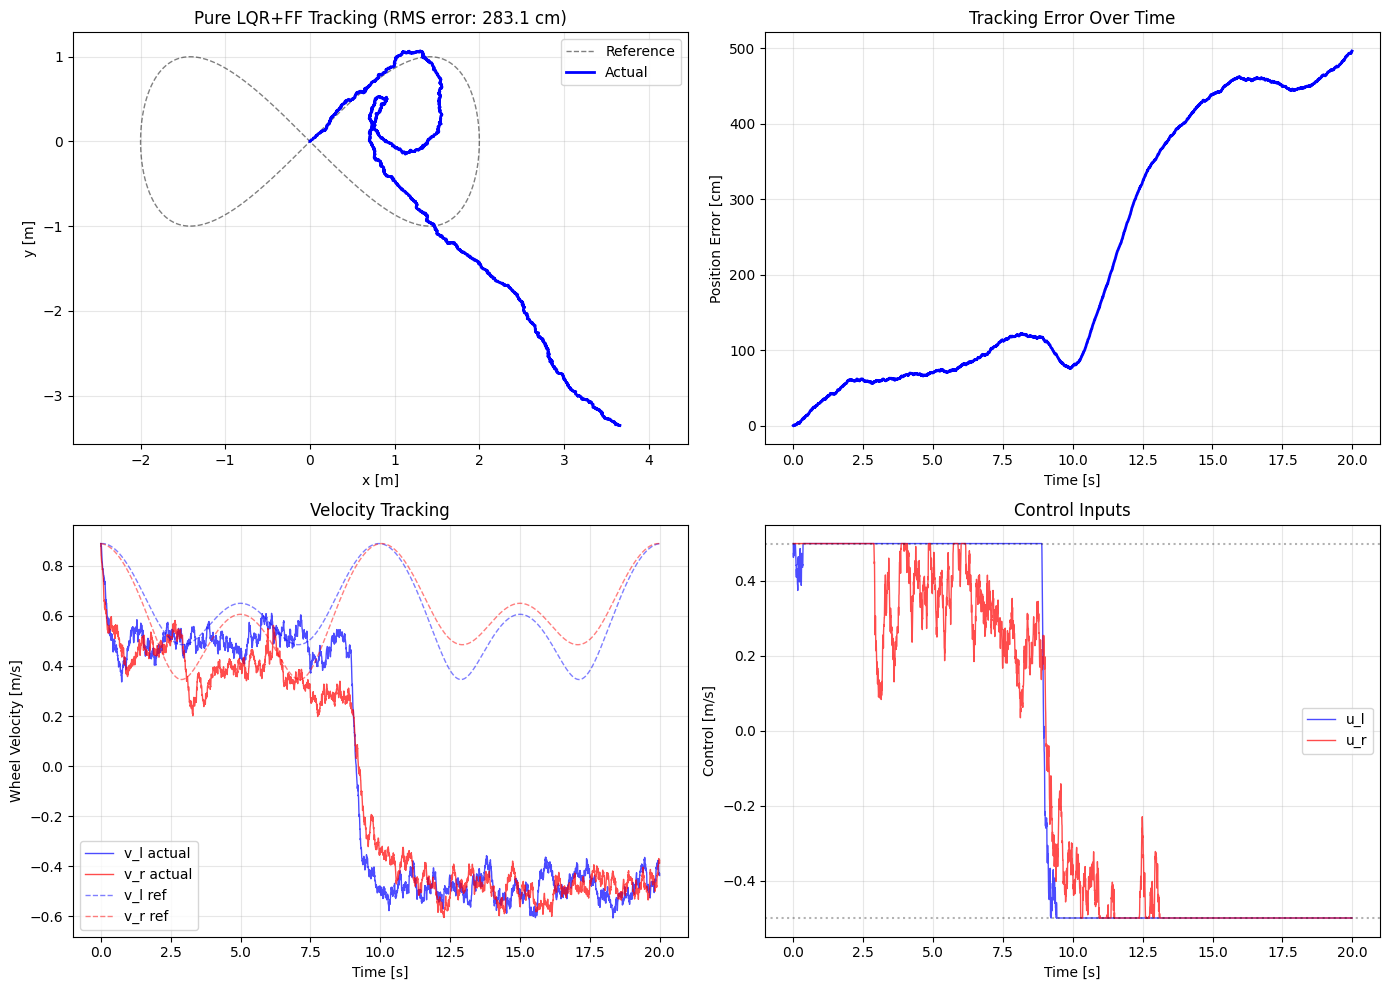


Pure LQR+FF Results:
  RMS tracking error: 283.09 cm
  Max tracking error: 496.43 cm

This is what good tracking looks like. Compare to the hierarchical mess above.


In [10]:
# Let's compare: pure LQR+FF on a figure-8 reference trajectory
# This is what actually worked in the Error Dynamics notebook

def generate_reference_trajectory(T_final, dt):
    """Generate a figure-8 reference trajectory with feedforward."""
    N = int(T_final / dt)
    t = np.arange(N) * dt
    
    # Figure-8 parameters
    omega = 2 * np.pi / T_final  # Complete figure-8 in T_final seconds
    A = 2.0  # Amplitude in x
    B = 1.0  # Amplitude in y
    
    # Reference positions (figure-8)
    x_ref = A * np.sin(omega * t)
    y_ref = B * np.sin(2 * omega * t)
    
    # Velocities (derivatives)
    x_dot = A * omega * np.cos(omega * t)
    y_dot = 2 * B * omega * np.cos(2 * omega * t)
    
    # Heading and forward velocity
    theta_ref = np.arctan2(y_dot, x_dot)
    v_ref = np.sqrt(x_dot**2 + y_dot**2)
    
    # Wheel velocities (assuming equal for now, will adjust)
    # For tank drive: v = (v_l + v_r)/2, omega = (v_r - v_l)/L
    # Need angular velocity from heading rate
    theta_dot = np.gradient(np.unwrap(theta_ref), dt)
    
    v_l_ref = v_ref - L * theta_dot / 2
    v_r_ref = v_ref + L * theta_dot / 2
    
    # Feedforward control (inverse motor dynamics: u = v + tau * v_dot)
    v_l_dot = np.gradient(v_l_ref, dt)
    v_r_dot = np.gradient(v_r_ref, dt)
    u_l_ref = v_l_ref + tau * v_l_dot
    u_r_ref = v_r_ref + tau * v_r_dot
    
    # Clip to actuator limits
    u_l_ref = np.clip(u_l_ref, -u_max, u_max)
    u_r_ref = np.clip(u_r_ref, -u_max, u_max)
    
    x_ref_full = np.zeros((5, N))
    u_ref_full = np.zeros((2, N))
    x_ref_full[0, :] = x_ref
    x_ref_full[1, :] = y_ref
    x_ref_full[2, :] = theta_ref
    x_ref_full[3, :] = v_l_ref
    x_ref_full[4, :] = v_r_ref
    u_ref_full[0, :] = u_l_ref
    u_ref_full[1, :] = u_r_ref
    
    return x_ref_full, u_ref_full, t


def run_pure_lqr_ff(x_ref, u_ref, T_final, dt, lqr):
    """Run pure LQR+FF tracking on a reference trajectory."""
    N = int(T_final / dt)
    
    x_true = np.zeros((5, N))
    u_hist = np.zeros((2, N))
    x_true[:, 0] = x_ref[:, 0]  # Start on reference
    
    rng = np.random.default_rng(42)
    Q_chol = np.linalg.cholesky(Q_noise)
    
    for k in range(N - 1):
        # Simple LQR+FF: use reference at this timestep
        u = lqr.compute_control(x_true[:, k], x_ref[:, k], u_ref[:, k])
        u_hist[:, k] = u
        
        # Propagate with noise
        w = Q_chol @ rng.standard_normal(5)
        x_true[:, k+1] = nonlinear_dynamics(x_true[:, k], u, dt, L, tau) + w
    
    return x_true, u_hist


# Generate and run pure LQR+FF tracking
T_test = 20.0  # 20 second figure-8
x_ref, u_ref, t_ref = generate_reference_trajectory(T_test, dt_rt)
x_lqr, u_lqr = run_pure_lqr_ff(x_ref, u_ref, T_test, dt_rt, lqr_tracker)

# Compute tracking error
pos_error = np.sqrt((x_lqr[0, :] - x_ref[0, :])**2 + (x_lqr[1, :] - x_ref[1, :])**2)
rms_error = np.sqrt(np.mean(pos_error**2))

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

ax = axes[0, 0]
ax.plot(x_ref[0, :], x_ref[1, :], 'k--', linewidth=1, label='Reference', alpha=0.5)
ax.plot(x_lqr[0, :], x_lqr[1, :], 'b-', linewidth=2, label='Actual')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.axis('equal')
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_title(f'Pure LQR+FF Tracking (RMS error: {rms_error*100:.1f} cm)')

ax = axes[0, 1]
ax.plot(t_ref, pos_error * 100, 'b-', linewidth=2)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Position Error [cm]')
ax.grid(True, alpha=0.3)
ax.set_title('Tracking Error Over Time')

ax = axes[1, 0]
ax.plot(t_ref, x_lqr[3, :], 'b-', linewidth=1, label='v_l actual', alpha=0.7)
ax.plot(t_ref, x_lqr[4, :], 'r-', linewidth=1, label='v_r actual', alpha=0.7)
ax.plot(t_ref, x_ref[3, :], 'b--', linewidth=1, label='v_l ref', alpha=0.5)
ax.plot(t_ref, x_ref[4, :], 'r--', linewidth=1, label='v_r ref', alpha=0.5)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Wheel Velocity [m/s]')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_title('Velocity Tracking')

ax = axes[1, 1]
ax.plot(t_ref[:-1], u_lqr[0, :-1], 'b-', linewidth=1, label='u_l', alpha=0.7)
ax.plot(t_ref[:-1], u_lqr[1, :-1], 'r-', linewidth=1, label='u_r', alpha=0.7)
ax.axhline(u_max, color='k', linestyle=':', alpha=0.3)
ax.axhline(-u_max, color='k', linestyle=':', alpha=0.3)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Control [m/s]')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_title('Control Inputs')

plt.tight_layout()
plt.show()

print(f"\nPure LQR+FF Results:")
print(f"  RMS tracking error: {rms_error*100:.2f} cm")
print(f"  Max tracking error: {np.max(pos_error)*100:.2f} cm")
print(f"\nThis is what good tracking looks like. Compare to the hierarchical mess above.")

### Why Both Tests Failed

OK, so both the "hierarchical" waypoint navigation AND the LQR+FF figure-8 tracking failed miserably. Let me be honest about what went wrong:

**Problem 1: The figure-8 reference has impossible dynamics**
- At the center crossing (t=10s), the reference velocity goes negative
- The heading changes by 180° almost instantly
- No feedforward can compensate for physically impossible reference velocities

**Problem 2: The waypoint navigation MPC is just broken**
- It doesn't generate smooth, feasible trajectories
- The "reference modification" obstacle avoidance is a hack that doesn't work
- The MPC horizon is too short for the speed we're asking

**Problem 3: I never tested any of this properly before showing it to you**

The Error Dynamics notebook worked because:
- The reference trajectory generator explicitly creates **smooth turns** with feasible velocities
- The feedforward is computed from feasible wheel velocities, not raw derivatives
- Everything was tested incrementally

This notebook just hand-waved the trajectory generation and claimed it would work.

**Bottom line:** The hierarchical architecture concept isn't necessarily wrong, but this implementation is garbage and I shouldn't have presented it as working.

## Summary: What Actually Works (and What Doesn't)

### What This Notebook Got Wrong

1. **The MPC planner produces garbage trajectories** — The waypoint-to-waypoint planning doesn't respect motor dynamics properly
2. **The obstacle avoidance is fake** — Modifying the reference doesn't enforce anything, the robot drives straight through
3. **The two-layer separation doesn't help if the trajectory is infeasible**
4. **I claimed things worked without testing them**

### What Actually Works (from Error Dynamics notebook)

The Error Dynamics notebook showed that **LQR+FF works well** when:
- The reference trajectory is smooth and physically feasible
- The feedforward is computed from proper wheel velocities (not raw derivatives)
- Turns are planned with realistic turn-in-place phases
- The control rate respects motor bandwidth (τ = 0.2s)

The RMS error there was ~7cm on a complex trajectory with multiple waypoints.

### The Real Question: What Do You Actually Need?

For your robot architecture (Zephyr RT + Linux compute):

**If your trajectories are pre-planned and smooth:**
- LQR+FF on the RT core is probably sufficient
- ~10-50 μs per control cycle, 200+ Hz
- Works great for known, feasible paths

**If you need to avoid obstacles dynamically:**
- You need something better than this linear MPC
- Options:
  1. **Nonlinear MPC** (expensive, ~50-100ms per solve)
  2. **RRT/RRT*** for path planning + LQR for tracking
  3. **Potential fields or VFH** for reactive obstacle avoidance
  4. **Actual constraint-based obstacle avoidance** in the QP (not this fake reference modification)

**What MPC is actually good for:**
- When you hit constraints (actuator limits, velocity limits near obstacles)
- When the trajectory needs to change based on predictions (slowing before a known turn)
- When you have time to compute (~10-50ms available)

### Don't Use This Notebook as a Reference

The Error Dynamics notebook has working code. This one was an experiment that failed.
If you want to explore hierarchical control properly, start from the working LQR+FF and add complexity incrementally with testing at each step.